In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np

In [2]:
spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/09 11:29:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/09 11:30:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58889)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/accumulators.py", line 299, in handle
    poll(accum_updates)
  File "/Library/Frameworks/Pyt

# Similarity calculation

In [69]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def compute_poincare_similarities(
    df: DataFrame,
    output_parquet_path: str = None,
    similarity_mode: str = "inverse_distance",
    epsilon: float = 1e-9,
    debug: bool = False
) -> DataFrame:
    """
    Compute pairwise Poincaré similarities between targets within each disease.
    """
    # --- Handle pathwayIds (split into arrays) ---
    df = df.withColumn("pathwayIdsArr", F.split(F.col("pathwayIds"), ","))

    # Find and order hyperbolic coord columns
    dim_cols = sorted([c for c in df.columns if c.startswith("dim_")], 
                      key=lambda c: int(c.split("_")[1]))
    if not dim_cols:
        raise ValueError("No dim_* columns found.")

    # Build arrays for vectorized UDF input
    dfv = df.select(
        "diseaseId",
        "targetId",
        "approvedSymbol",
        "pathwayIdsArr",
        F.array(*[F.col(c).cast("double") for c in dim_cols]).alias("vec")
    ).repartition("diseaseId")

    # --- Sanitize vectors: replace NaN/null with 0 ---
    dfv = dfv.withColumn(
        "vec",
        F.expr("transform(vec, x -> CASE WHEN isnan(x) OR x IS NULL THEN 0.0 ELSE x END)")
    )
    
    # Self-join within disease, upper triangle only
    a = dfv.alias("a")
    b = dfv.alias("b")
    pairs = (
        a.join(b, on="diseaseId")
         .where(F.col("a.targetId") < F.col("b.targetId"))
    )

    # --- Helper functions ---
    @F.udf("double")
    def poincare_distance(vec_a, vec_b):
        import math
        if vec_a is None or vec_b is None:
            return None
            
        # Convert to floats and handle any remaining NaNs
        ua = [0.0 if x is None or math.isnan(x) else float(x) for x in vec_a]
        ub = [0.0 if x is None or math.isnan(x) else float(x) for x in vec_b]
        
        # Ensure vectors are same length
        if len(ua) != len(ub):
            min_len = min(len(ua), len(ub))
            ua = ua[:min_len]
            ub = ub[:min_len]

        norm_a2 = sum(x*x for x in ua)
        norm_b2 = sum(x*x for x in ub)

        # Scale vectors to stay within unit ball
        if norm_a2 >= 1.0:
            scale = (1.0 - epsilon) / math.sqrt(norm_a2)
            ua = [x * scale for x in ua]
            norm_a2 = sum(x*x for x in ua)
        if norm_b2 >= 1.0:
            scale = (1.0 - epsilon) / math.sqrt(norm_b2)
            ub = [x * scale for x in ub]
            norm_b2 = sum(x*x for x in ub)

        diff2 = sum((x - y)**2 for x, y in zip(ua, ub))
        denom = (1.0 - norm_a2) * (1.0 - norm_b2)

        if denom <= 0:
            return None

        z = 1.0 + (2.0 * diff2) / denom
        if z < 1.0:
            return None

        try:
            return float(math.acosh(z))
        except:
            return None

    @F.udf("double")
    def to_similarity(d):
        import math
        if d is None or math.isnan(d):
            return None
        if similarity_mode == "inverse_distance":
            return 1.0 / (1.0 + d)
        elif similarity_mode == "exp_decay":
            return math.exp(-d)
        elif similarity_mode == "negative_distance":
            return -d
        else:
            return 1.0 / (1.0 + d)

    # --- Main scoring ---
    scored = (
        pairs.select(
            F.col("a.diseaseId").alias("diseaseId"),
            F.col("a.targetId").alias("targetIdA"),
            F.col("a.approvedSymbol").alias("approvedSymbolA"),
            F.col("b.targetId").alias("targetIdB"),
            F.col("b.approvedSymbol").alias("approvedSymbolB"),
            F.col("a.pathwayIdsArr").alias("pathwayIdsArrA"),
            F.col("b.pathwayIdsArr").alias("pathwayIdsArrB"),
            poincare_distance(F.col("a.vec"), F.col("b.vec")).alias("distance"),
            F.array_intersect(F.col("a.pathwayIdsArr"), F.col("b.pathwayIdsArr")).alias("commonPathwayIdsArr")
        )
        .withColumn("similarScore", to_similarity(F.col("distance")))
        .withColumn("commonPathwayIds", F.array_join(F.col("commonPathwayIdsArr"), ","))
        .drop("distance", "commonPathwayIdsArr")
    )

    # --- Enhanced debug output ---
    if debug:
        @F.udf("struct<distance:double, denom:double, z:double, norm_a2:double, norm_b2:double, diff2:double>")
        def poincare_debug(vec_a, vec_b):
            import math
            if vec_a is None or vec_b is None:
                return None
                
            ua = [0.0 if x is None or math.isnan(x) else float(x) for x in vec_a]
            ub = [0.0 if x is None or math.isnan(x) else float(x) for x in vec_b]
            
            if len(ua) != len(ub):
                min_len = min(len(ua), len(ub))
                ua = ua[:min_len]
                ub = ub[:min_len]

            norm_a2 = sum(x*x for x in ua)
            norm_b2 = sum(x*x for x in ub)

            if norm_a2 >= 1.0:
                scale = (1.0 - epsilon) / math.sqrt(norm_a2)
                ua = [x * scale for x in ua]
                norm_a2 = sum(x*x for x in ua)
            if norm_b2 >= 1.0:
                scale = (1.0 - epsilon) / math.sqrt(norm_b2)
                ub = [x * scale for x in ub]
                norm_b2 = sum(x*x for x in ub)

            diff2 = sum((x-y)**2 for x, y in zip(ua, ub))
            denom = (1.0 - norm_a2) * (1.0 - norm_b2)

            if denom <= 0:
                return {"distance": None, "denom": denom, "z": None, 
                        "norm_a2": norm_a2, "norm_b2": norm_b2, "diff2": diff2}

            z = 1.0 + (2.0 * diff2) / denom
            if z < 1.0:
                return {"distance": None, "denom": denom, "z": z, 
                        "norm_a2": norm_a2, "norm_b2": norm_b2, "diff2": diff2}

            try:
                d_val = math.acosh(z)
            except:
                d_val = float('nan')
                
            return {"distance": d_val, "denom": denom, "z": z, 
                    "norm_a2": norm_a2, "norm_b2": norm_b2, "diff2": diff2}

        debug_df = pairs.withColumn("dbg", poincare_debug(F.col("a.vec"), F.col("b.vec")))
        problematic = debug_df.filter(
            F.isnan("dbg.distance") | 
            F.col("dbg.distance").isNull() |
            F.isnan("dbg.z") |
            (F.col("dbg.denom") <= 0)
        )
        print(f"Found {problematic.count()} problematic pairs")
        problematic.select(
            "diseaseId", "a.targetId", "b.targetId",
            "dbg.denom", "dbg.z", "dbg.distance",
            "dbg.norm_a2", "dbg.norm_b2", "dbg.diff2"
        ).show(50, truncate=False)

    # --- Optional write ---
    if output_parquet_path is not None:
        (scored
         .repartition("diseaseId")
         .write
         .mode("overwrite")
         .partitionBy("diseaseId")
         .parquet(output_parquet_path))

    return scored

In [70]:
input_parquet_test = spark.read.parquet("/Users/polina/Pathwaganda/data/tem_levels/0").filter(col("diseaseId") == "MONDO_0004975")

In [71]:
sim_level0 = compute_poincare_similarities(input_parquet_test, debug=True)

Found 0 problematic pairs


+---------+--------+--------+-----+---+--------+-------+-------+-----+
|diseaseId|targetId|targetId|denom|z  |distance|norm_a2|norm_b2|diff2|
+---------+--------+--------+-----+---+--------+-------+-------+-----+
+---------+--------+--------+-----+---+--------+-------+-------+-----+



In [72]:
sim_level0.show(10)

+-------------+---------------+---------------+---------------+---------------+--------------------+--------------------+-------------------+--------------------+
|    diseaseId|      targetIdA|approvedSymbolA|      targetIdB|approvedSymbolB|      pathwayIdsArrA|      pathwayIdsArrB|       similarScore|    commonPathwayIds|
+-------------+---------------+---------------+---------------+---------------+--------------------+--------------------+-------------------+--------------------+
|MONDO_0004975|ENSG00000005961|         ITGA2B|ENSG00000179388|           EGR3|[R-HSA-9675108, R...|     [R-HSA-9006934]| 0.2183781862706985|                    |
|MONDO_0004975|ENSG00000005961|         ITGA2B|ENSG00000172201|            ID4|[R-HSA-9675108, R...|     [R-HSA-9006934]| 0.2183781862706985|                    |
|MONDO_0004975|ENSG00000005961|         ITGA2B|ENSG00000198898|         CAPZA2|[R-HSA-9675108, R...|[R-HSA-168256, R-...|0.25045982846561937|                    |
|MONDO_0004975|ENSG000

In [73]:
# Check that amount of diseases is the same after this operation
sim_level0.select("diseaseId").distinct().count()

1

In [74]:
sim_level0_filt = sim_level0.filter(col("diseaseId") == "MONDO_0004975")

In [79]:
sim_level0_filt.sort("similarScore", ascending=False).filter(col("commonPathwayIds") == "").show(30, truncate=False)

+-------------+-------------------------------+---------------+-------------------------------+---------------+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+----------------+
|diseaseId    |targetIdA                      |approvedSymbolA|targetIdB                      |approvedSymbolB|pathwayIdsArrA               |pathwayIdsArrB                                                                                                                                             |similarScore      |commonPathwayIds|
+-------------+-------------------------------+---------------+-------------------------------+---------------+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+----------------

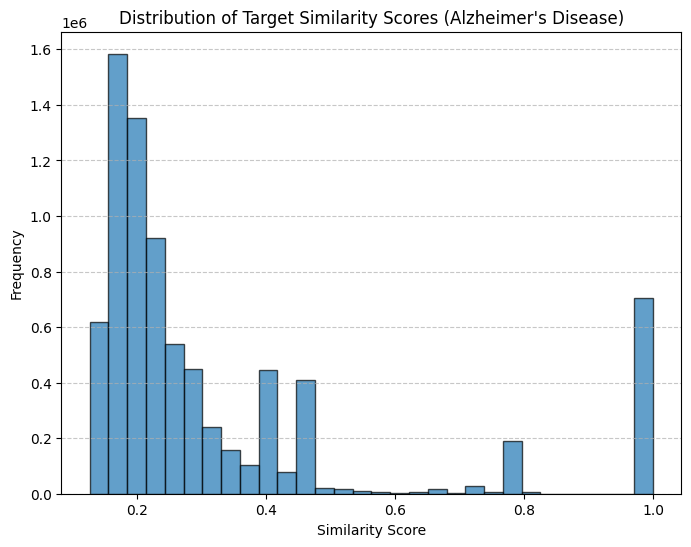

In [78]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Ensure numeric column and drop nulls
df_clean = sim_level0_filt.withColumn(
    "similarScore", F.col("similarScore").cast("double")
).na.drop(subset=["similarScore"])

# Convert column to RDD
rdd_scores = df_clean.select("similarScore").rdd.map(lambda row: row[0])

# Compute histogram with Spark (e.g., 30 bins)
hist = rdd_scores.histogram(30)   # returns (bin_edges, counts)

bin_edges, counts = hist

# Plot histogram
plt.figure(figsize=(8,6))
plt.bar(bin_edges[:-1], counts, width=[bin_edges[i+1]-bin_edges[i] for i in range(len(bin_edges)-1)],
        align="edge", edgecolor="black", alpha=0.7)
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Target Similarity Scores (Alzheimer's Disease)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [94]:
input_parquet_test2 = spark.read.parquet("/Users/polina/Pathwaganda/data/tem_levels/2").filter(col("diseaseId") == "EFO_0000756")

In [95]:
sim_level2 = compute_poincare_similarities(input_parquet_test2, debug=True)

Found 0 problematic pairs


+---------+--------+--------+-----+---+--------+-------+-------+-----+
|diseaseId|targetId|targetId|denom|z  |distance|norm_a2|norm_b2|diff2|
+---------+--------+--------+-----+---+--------+-------+-------+-----+
+---------+--------+--------+-----+---+--------+-------+-------+-----+



In [96]:
sim_level2.show(5)

+-----------+---------------+---------------+---------------+---------------+--------------------+--------------------+-------------------+----------------+
|  diseaseId|      targetIdA|approvedSymbolA|      targetIdB|approvedSymbolB|      pathwayIdsArrA|      pathwayIdsArrB|       similarScore|commonPathwayIds|
+-----------+---------------+---------------+---------------+---------------+--------------------+--------------------+-------------------+----------------+
|EFO_0000756|ENSG00000141582|           CBX4|ENSG00000205726|          ITSN1|[R-HSA-6807070, R...|      [R-HSA-422475]| 0.2625336843194644|                |
|EFO_0000756|ENSG00000141582|           CBX4|ENSG00000176749|         CDK5R1|[R-HSA-6807070, R...|[R-HSA-212436, R-...| 0.5572141717177281|    R-HSA-212436|
|EFO_0000756|ENSG00000141582|           CBX4|ENSG00000147416|       ATP6V1B2|[R-HSA-6807070, R...|[R-HSA-74752, R-H...|0.41218202761812095|                |
|EFO_0000756|ENSG00000141582|           CBX4|ENSG000002116

In [104]:
from pyspark.sql.functions import col, concat_ws

sim_level2_test = sim_level2.sort("similarScore", ascending=False).filter(col("commonPathwayIds") == "") \
                            .withColumn("pathwayIdsArrA", concat_ws(",", col("pathwayIdsArrA"))) \
                            .withColumn("pathwayIdsArrB", concat_ws(",", col("pathwayIdsArrB")))
sim_level2_test.write.csv("/Users/polina/Pathwaganda/data/sim_levels/test/sim_level2_no_pathways.csv", header=True, mode="overwrite")

In [ ]:
sim_level2_test.show()

+-----------+---------------+---------------+--------------------+---------------+--------------------+--------------------+------------------+----------------+
|  diseaseId|      targetIdA|approvedSymbolA|           targetIdB|approvedSymbolB|      pathwayIdsArrA|      pathwayIdsArrB|      similarScore|commonPathwayIds|
+-----------+---------------+---------------+--------------------+---------------+--------------------+--------------------+------------------+----------------+
|EFO_0000756|ENSG00000150455|          TIRAP|     ENSG00000179639|         FCER1A|R-HSA-166058,R-HS...|       R-HSA-2454202|0.9943528544173986|                |
|EFO_0000756|ENSG00000150455|          TIRAP|     ENSG00000240382|       IGKV1-17|R-HSA-166058,R-HS...|R-HSA-2871796,R-H...|0.9943528544173986|                |
|EFO_0000756|ENSG00000150455|          TIRAP|     ENSG00000211660|       IGLV2-23|R-HSA-166058,R-HS...|R-HSA-2871796,R-H...|0.9943528544173986|                |
|EFO_0000756|ENSG00000150455|     

25/09/09 19:45:12 WARN TransportChannelHandler: Exception in connection from /172.23.50.127:58847
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:796)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptim

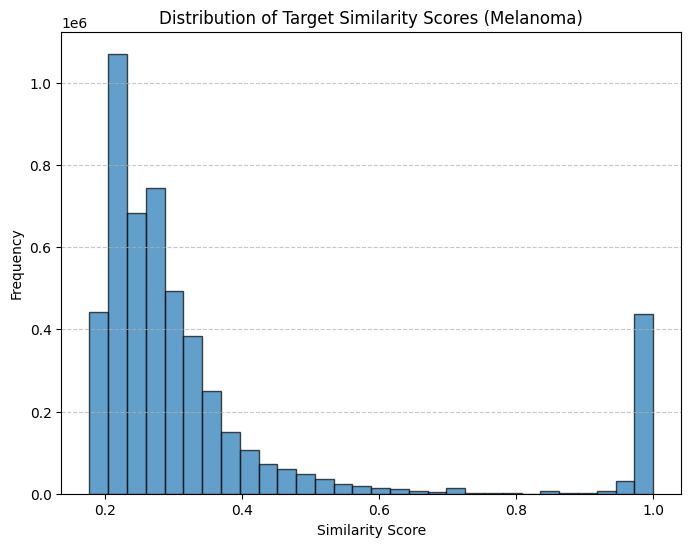

In [99]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Ensure numeric column and drop nulls
df_clean = sim_level2.withColumn(
    "similarScore", F.col("similarScore").cast("double")
).na.drop(subset=["similarScore"])

# Convert column to RDD
rdd_scores = df_clean.select("similarScore").rdd.map(lambda row: row[0])

# Compute histogram with Spark (e.g., 30 bins)
hist = rdd_scores.histogram(30)   # returns (bin_edges, counts)

bin_edges, counts = hist

# Plot histogram
plt.figure(figsize=(8,6))
plt.bar(bin_edges[:-1], counts, width=[bin_edges[i+1]-bin_edges[i] for i in range(len(bin_edges)-1)],
        align="edge", edgecolor="black", alpha=0.7)
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Target Similarity Scores (Melanoma)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [19]:
sim_level2_new = compute_poincare_similarities(input_parquet_path = "/Users/polina/Pathwaganda/data/tem_levels/2")

In [46]:
sim_level1 = compute_poincare_similarities(input_parquet_path = "/Users/polina/Pathwaganda/data/tem_levels/1")

In [47]:
sim_level2 = compute_poincare_similarities(input_parquet_path = "/Users/polina/Pathwaganda/data/tem_levels/2")

In [ ]:
sim_level2.show(25)

+-----------+---------------+---------------+---------------+---------------+-------------------+----------------+
|  diseaseId|      targetIdA|approvedSymbolA|      targetIdB|approvedSymbolB|       similarScore|commonPathwayIds|
+-----------+---------------+---------------+---------------+---------------+-------------------+----------------+
|EFO_0005803|ENSG00000096264|           NCR2|ENSG00000127418|         FGFRL1|0.23141577391904944|                |
|EFO_0005803|ENSG00000096264|           NCR2|ENSG00000167772|        ANGPTL4|0.19362613348678467|                |
|EFO_0005803|ENSG00000096264|           NCR2|ENSG00000177302|          TOP3A|  0.282482787962711|                |
|EFO_0005803|ENSG00000096264|           NCR2|ENSG00000211677|          IGLC2|0.42901729706589103|                |
|EFO_0005803|ENSG00000096264|           NCR2|ENSG00000125398|           SOX9|0.22785641904153134|                |
+-----------+---------------+---------------+---------------+---------------+---

In [49]:
sim_level2.filter((col("approvedSymbolA") == "CDK2") & (col("approvedSymbolB") == "CDK4")).show(5)

+-----------+---------------+---------------+---------------+---------------+-------------------+--------------------+
|  diseaseId|      targetIdA|approvedSymbolA|      targetIdB|approvedSymbolB|       similarScore|    commonPathwayIds|
+-----------+---------------+---------------+---------------+---------------+-------------------+--------------------+
|EFO_0000313|ENSG00000123374|           CDK2|ENSG00000135446|           CDK4| 0.6970239959175557|R-HSA-212436,R-HS...|
|EFO_0000319|ENSG00000123374|           CDK2|ENSG00000135446|           CDK4| 0.5500472420363286|R-HSA-8848021,R-H...|
|EFO_0000508|ENSG00000123374|           CDK2|ENSG00000135446|           CDK4| 0.6498712628357501|R-HSA-912446,R-HS...|
|EFO_0000616|ENSG00000123374|           CDK2|ENSG00000135446|           CDK4| 0.6878854869170765|R-HSA-2559583,R-H...|
|EFO_0000618|ENSG00000123374|           CDK2|ENSG00000135446|           CDK4|0.37127843065302685|        R-HSA-212436|
+-----------+---------------+---------------+---

In [22]:
sim_level2_new.select("diseaseId").distinct().show(truncate=False)

+-------------+
|diseaseId    |
+-------------+
|EFO_0000508  |
|EFO_0004586  |
|EFO_0004747  |
|EFO_0005803  |
|EFO_0009676  |
|EFO_1001331  |
|MONDO_0002715|
|MONDO_0007254|
|MONDO_0021066|
|MONDO_0021148|
|MONDO_0023370|
|EFO_0000618  |
|EFO_0001444  |
|EFO_0003869  |
|EFO_0004198  |
|EFO_0004503  |
|EFO_0006858  |
|EFO_1000051  |
|EFO_1000363  |
|HP_0000118   |
+-------------+
only showing top 20 rows


In [23]:
sim_level2_new.select("diseaseId").distinct().count()

33

In [24]:
sim_level2_filt = sim_level2_new.filter(col("diseaseId") == "MONDO_0007254")

In [25]:
sim_level2_filt.show(5)

+-------------+---------------+---------------+--------------------+---------------+--------------+--------------------+-------------------+----------------+
|    diseaseId|      targetIdA|approvedSymbolA|           targetIdB|approvedSymbolB|pathwayIdsArrA|      pathwayIdsArrB|       similarScore|commonPathwayIds|
+-------------+---------------+---------------+--------------------+---------------+--------------+--------------------+-------------------+----------------+
|MONDO_0007254|ENSG00000111704|          NANOG|     ENSG00000198171|         DDRGK1|[R-HSA-449147]|[R-HSA-194315, R-...|0.22639717200191709|                |
|MONDO_0007254|ENSG00000111704|          NANOG|     ENSG00000132855|        ANGPTL3|[R-HSA-449147]|     [R-HSA-9024446]|0.22925657788298365|                |
|MONDO_0007254|ENSG00000111704|          NANOG|     ENSG00000133119|           RFC3|[R-HSA-449147]|[R-HSA-3700989, R...| 0.3104496237583337|                |
|MONDO_0007254|ENSG00000111704|          NANOG|     

In [ ]:
sim_level2_filt.sort("similarScore", ascending=False).filter(col("commonPathwayIds") == "").show(10)

+-------------+---------------+---------------+---------------+---------------+--------------------+--------------------+------------------+----------------+
|    diseaseId|      targetIdA|approvedSymbolA|      targetIdB|approvedSymbolB|      pathwayIdsArrA|      pathwayIdsArrB|      similarScore|commonPathwayIds|
+-------------+---------------+---------------+---------------+---------------+--------------------+--------------------+------------------+----------------+
|MONDO_0007254|ENSG00000156711|         MAPK13|ENSG00000162959|          MEMO1|[R-HSA-166520, R-...|[R-HSA-1227986, R...|0.9905990960358039|                |
|MONDO_0007254|ENSG00000156711|         MAPK13|ENSG00000181852|          RNF41|[R-HSA-166520, R-...|[R-HSA-1227986, R...|0.9905990960358039|                |
|MONDO_0007254|ENSG00000156711|         MAPK13|ENSG00000171132|          PRKCE|[R-HSA-166520, R-...|[R-HSA-1227986, R...|0.9905990960358039|                |
|MONDO_0007254|ENSG00000007264|           MATK|ENSG0

25/09/08 20:43:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1053264 ms exceeds timeout 120000 ms
25/09/08 20:43:47 WARN SparkContext: Killing executors is not supported by current scheduler.
25/09/08 21:00:37 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

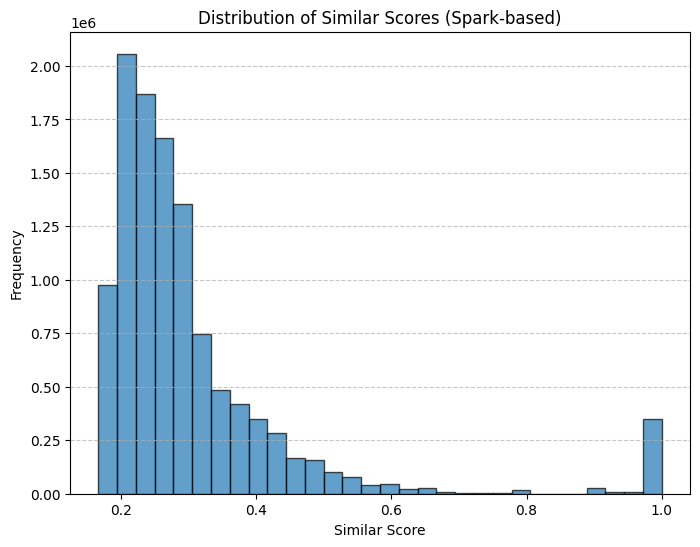

In [27]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Ensure numeric column and drop nulls
df_clean = sim_level2_filt.withColumn(
    "similarScore", F.col("similarScore").cast("double")
).na.drop(subset=["similarScore"])

# Convert column to RDD
rdd_scores = df_clean.select("similarScore").rdd.map(lambda row: row[0])

# Compute histogram with Spark (e.g., 30 bins)
hist = rdd_scores.histogram(30)   # returns (bin_edges, counts)

bin_edges, counts = hist

# Plot histogram
plt.figure(figsize=(8,6))
plt.bar(bin_edges[:-1], counts, width=[bin_edges[i+1]-bin_edges[i] for i in range(len(bin_edges)-1)],
        align="edge", edgecolor="black", alpha=0.7)
plt.xlabel("Similar Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similar Scores (Spark-based)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
